In [22]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
import math

In [23]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0    
nfreq = 1

In [45]:
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

tpml = 0.4

boundary_layers = [
    mp.PML(tpml, direction=mp.Y),
    mp.PML(tpml, direction=mp.X)
]

tag_bot   = 0.5
tsio2     = 4
tag_side  = 4
design_region_height = 0.5
monitor_position     = 0.5 * 2
monitor_blank        = 0.5 * 0.1

width_ag       = 0.2
width_sio2     = 2
width_bot_ag   = round(width_ag + width_sio2 + width_ag, 2)
design_region_width  = round(width_bot_ag, 3)

Sx = 12
Sy = 12

y_bottom = -Sy/2 + tpml
center_y_ag        = y_bottom + tag_bot/2
center_y_sio2      = y_bottom + tag_bot + tsio2/2
center_y_design    = y_bottom + tag_bot + tsio2 + design_region_height/2
center_y_monitor_position   = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
# center_y_source_position    = y_bottom + tag_bot + 5/fcen  # 예시
center_y_source_position    = y_bottom + tag_bot + 1/fcen  # 예시
center_Ag_x_offset = design_region_width/2 - width_ag/2

Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1

geometry = [

]

In [46]:
src = mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(0, 0, 0)
    )

In [53]:
Sx, Sy  = 20.0 + tpml*2, 20.0 + tpml*2
margin  = 0.3

monitor_size = 20
cell_size   = mp.Vector3(Sx, Sy)

mon_size, mon_center = mp.Vector3(monitor_size, 0), mp.Vector3(0,monitor_size/2-1/resolution)

In [54]:
Lx = Sx - 2*tpml
Ly = Sy - 2*tpml - 2*margin
assert Lx > 0 and Ly > 0, "라인 길이가 0 이하입니다. margin/tpml/Sx/Sy 확인"

<Axes: xlabel='X', ylabel='Y'>

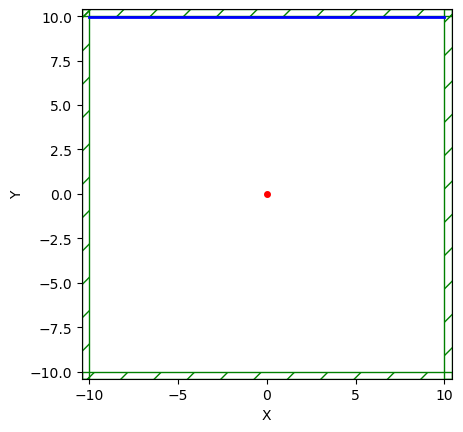

In [61]:
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(tpml, mp.X), mp.PML(tpml, mp.Y)],
    geometry=geometry,                    # 네 구조가 있으면 그대로 사용
    sources=[src],
    default_material=Air
)# 3) DFT 포인트 모니터(주파수 스윕)
#    add_dft_fields(fcen, df, nfreq) → [fcen - df/2, fcen + df/2] 구간
dft_top = sim.add_dft_fields([mp.Ez], fcen, df, nfreq,
                             center=mon_center, size=mon_size)
# dft_bot = sim.add_dft_fields([mp.Ez], fcen, df, nfreq,
#                              center=mp.Vector3(0, -Ry, 0), size=mp.Vector3(Lx, 0, 0))
# dft_rgt = sim.add_dft_fields([mp.Ez], fcen, df, nfreq,
#                              center=mp.Vector3(+Rx, 0, 0), size=mp.Vector3(0, Ly, 0))
# dft_lft = sim.add_dft_fields([mp.Ez], fcen, df, nfreq,
#                              center=mp.Vector3(-Rx, 0, 0), size=mp.Vector3(0, Ly, 0))
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

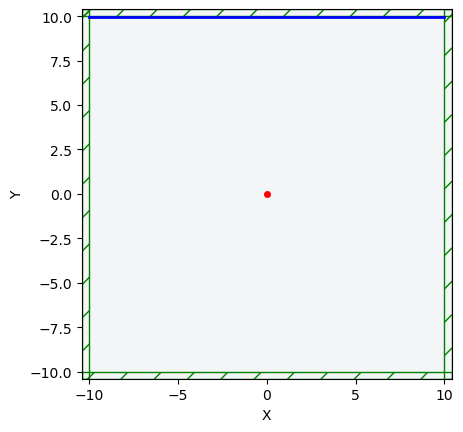

In [59]:
sim.plot2D(fields = mp.Ez)

In [56]:
sim.run(until_after_sources=mp.stop_when_dft_decayed())

-----------
Initializing structure...
time for choose_chunkdivision = 0.000342131 s
Working in 2D dimensions.
Computational cell is 20.8 x 20.8 x 0 with resolution 50
time for set_epsilon = 0.533029 s
-----------
on time step 1527 (time=15.27), 0.0026204 s/step
on time step 3144 (time=31.44), 0.00247418 s/step
on time step 4630 (time=46.3), 0.00269223 s/step
on time step 6187 (time=61.87), 0.00256975 s/step
run 0 finished at t = 74.24 (7424 timesteps)


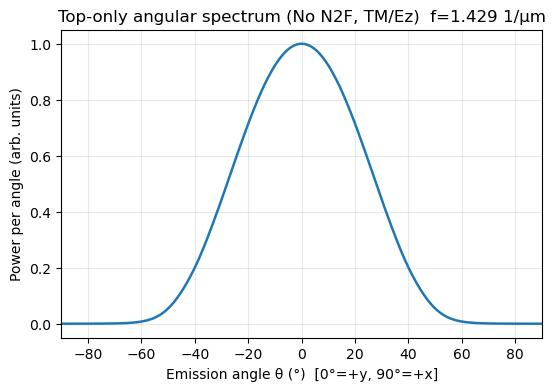

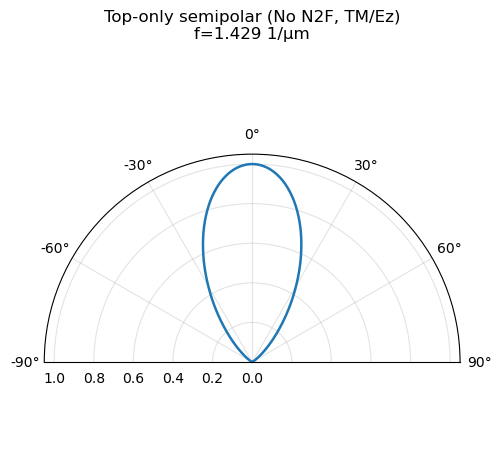

In [58]:
# ---------------- Top-only angular spectrum (No N2F, TM/Ez) ----------------
import numpy as np
import matplotlib.pyplot as plt

# 중앙 주파수 인덱스
freqs = np.linspace(fcen - 0.5*df, fcen + 0.5*df, nfreq)
fi0   = int(np.argmin(np.abs(freqs - fcen)))
f0    = float(freqs[fi0])
k0    = 2*np.pi*f0*1.0   # n=1 (air)

# 윗면 라인 DFT 복소장 (1D array)
Ez_top_f = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 run/수집 끝난 상태여야 함

# 라인 FFT -> kx 스펙트럼 (창함수+제로패딩), 전파성분만
dx   = 1.0 / resolution
N    = Ez_top_f.size
win  = np.hanning(N)
zf   = 8
Ek   = np.fft.fftshift(np.fft.fft(Ez_top_f * win, n=N*zf)) * dx
kx   = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N*zf, d=dx))

mask = np.abs(kx) <= k0                 # evanescent 제거
kx   = kx[mask]
Ek   = Ek[mask]
ky   = np.sqrt(np.maximum(k0**2 - kx**2, 0.0))  # 위쪽(ky>0)

# 각도 매핑(0°=+y, +90°=+x) 및 각도당 전력(자코비안 cosθ=ky/k0)
theta = np.degrees(np.arctan2(kx, ky))          # [-90°, +90°]
P     = (np.abs(Ek)**2) * (ky / k0)             # 정규화 없음(원값)

# 균일 각도축으로 보간(그래프 예쁘게)
theta_grid = np.linspace(-90, 90, 361)
P_grid     = np.interp(theta_grid, theta, P, left=0.0, right=0.0)

# 1) 카르테시안 플롯
plt.figure(figsize=(6.2,4.0))
plt.plot(theta_grid, P_grid/max(P_grid), lw=1.8)
plt.xlim(-90, 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")   # 정규화 없음
plt.title(f"Top-only angular spectrum (No N2F, TM/Ez)  f={f0:.3f} 1/µm")
plt.grid(True, alpha=0.3)
plt.show()

# 2) 반폴라(−90°~+90°) 플롯
theta_rad = np.deg2rad(theta_grid)
fig = plt.figure(figsize=(6.0,5.4))
ax  = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')  # 0°=위(+y)
ax.set_theta_direction(-1)       # 시계방향 증가(오른쪽이 +90°)
ax.set_thetamin(-90); ax.set_thetamax(90)
ax.plot(theta_rad, P_grid/max(P_grid), lw=1.8)
ax.set_rlabel_position(135)
ax.grid(True, alpha=0.35)
ax.set_title(f"Top-only semipolar (No N2F, TM/Ez)\nf={f0:.3f} 1/µm", va='bottom')
plt.show()
# ---------------------------------------------------------------------------


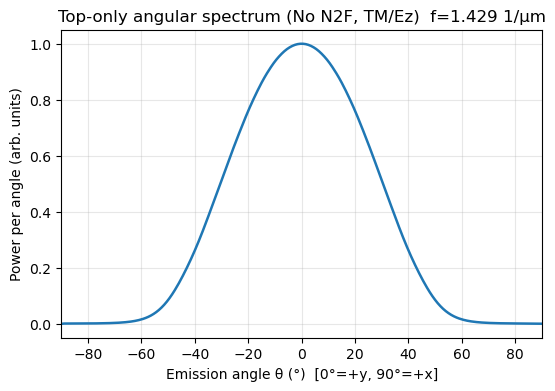

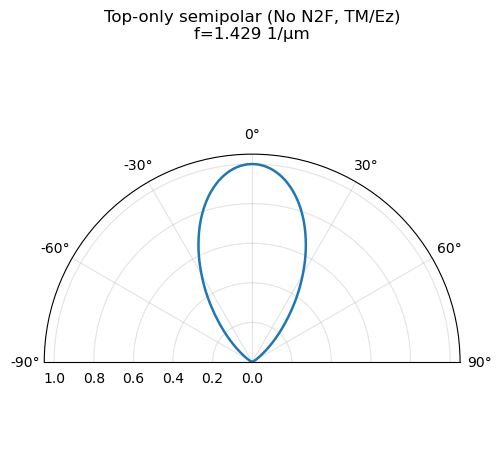

In [89]:
theta = np.arctan2(kx, ky)          # [rad]
# 물리 상수 (Meep 단위에서 c=μ=ε=η=1이라 단위계수 생략 가능)
omega = 2*np.pi*f0
k     = 2*np.pi*f0                   # = k0

# k-공간 평면파 관계(2D TM: Ez≠0, Ex=Ey=0)
# ∇×E = iωμH  → Hx =  ky/(ωμ) * Ez,   Hy = -kx/(ωμ) * Ez  (μ=1)
Hx = (ky/omega) * Ek
Hy = -(kx/omega) * Ek

# 포인팅 S = 1/2 Re{E × H*} = (Sx,Sy,0)
Sx = -0.5 * np.real(Ek * np.conj(Hy))
Sy =  0.5 * np.real(Ek * np.conj(Hx))

# 반경 성분 Sr = S·r̂ = Sx*sinθ + Sy*cosθ
Sr = Sx * np.sin(theta) + Sy * np.cos(theta)

# 균일 각도축으로 보간
theta_deg  = np.degrees(theta)             # [-90, +90]
theta_grid = np.linspace(-90, 90, 361)
P_grid     = np.interp(theta_grid, theta_deg, Sr, left=0.0, right=0.0)

# 플롯 (정규화 원하면 /max(P_grid) 해도 됨)
plt.figure(figsize=(6.2,4.0))
plt.plot(theta_grid, P_grid / (P_grid.max()+1e-18), lw=1.8)
plt.xlim(-90, 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title(f"Top-only angular spectrum (No N2F, TM/Ez)  f={f0:.3f} 1/µm")
plt.grid(True, alpha=0.3)
plt.show()

theta_rad = np.deg2rad(theta_grid)
fig = plt.figure(figsize=(6.0,5.4))
ax  = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')  # 0°=위(+y)
ax.set_theta_direction(-1)       # 시계방향 증가(오른쪽이 +90°)
ax.set_thetamin(-90); ax.set_thetamax(90)
ax.plot(theta_rad, P_grid/max(P_grid), lw=1.8)
ax.set_rlabel_position(135)
ax.grid(True, alpha=0.35)
ax.set_title(f"Top-only semipolar (No N2F, TM/Ez)\nf={f0:.3f} 1/µm", va='bottom')
plt.show()

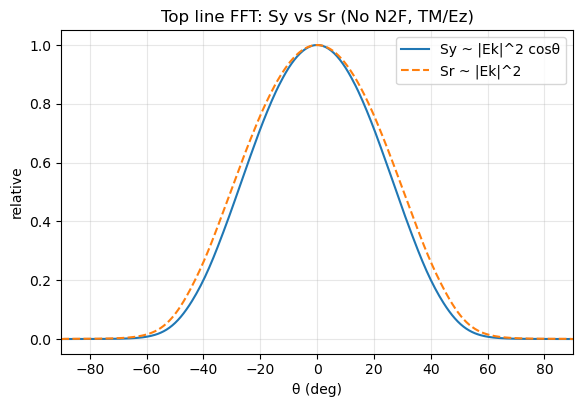

In [90]:
# kx, ky, Ek, theta (rad), theta_grid 등은 이미 위에서 계산했다고 가정
eps = 1e-12
P_Sy = (np.abs(Ek)**2) * (ky/k0)           # 라인 법선 플럭스(네가 쓰던 식)
P_Sr = (np.abs(Ek)**2)                     # 방사 반경 플럭스에 비례

# 동일한 θ 그리드로 보간
theta_deg  = np.degrees(theta)
theta_grid = np.linspace(-90, 90, 361)
Sy_grid = np.interp(theta_grid, theta_deg, P_Sy, left=0, right=0)
Sr_grid = np.interp(theta_grid, theta_deg, P_Sr, left=0, right=0)

# 정규화 없이 그려도 되고, 모양 비교만 원하면 /max
plt.figure(figsize=(6.6,4.2))
plt.plot(theta_grid, Sy_grid/(Sy_grid.max()+eps), label="Sy ~ |Ek|^2 cosθ")
plt.plot(theta_grid, Sr_grid/(Sr_grid.max()+eps), label="Sr ~ |Ek|^2", ls="--")
plt.xlim(-90,90); plt.xlabel("θ (deg)"); plt.ylabel("relative")
plt.title("Top line FFT: Sy vs Sr (No N2F, TM/Ez)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000222921 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 50
time for set_epsilon = 0.203861 s
-----------
run 0 finished at t = 9.34 (934 timesteps)
max |Ez_top| = 0.03639735171689631


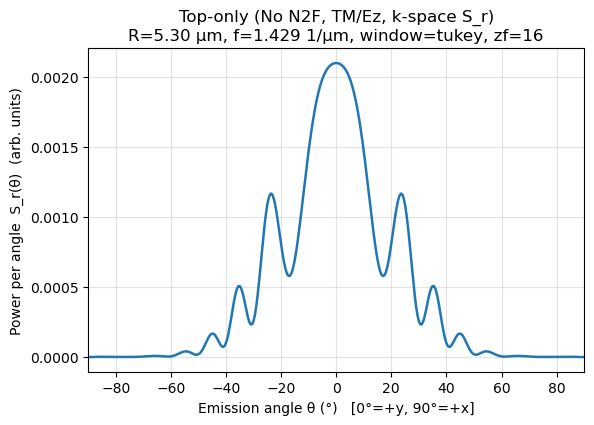

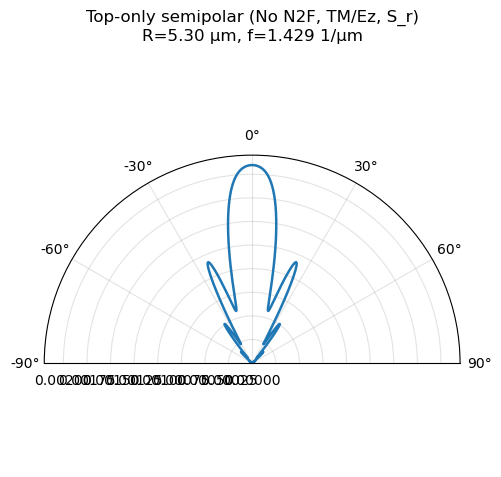

In [28]:
# ===== FINAL: Top-only angular spectrum using k-space radial Poynting (No N2F, TM/Ez) =====
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# --- 필수 파라미터는 네가 이미 정의했다고 가정 ---
# (fcen, df, nfreq, resolution, tpml, cell_size=mp.Vector3(Sx,Sy), geometry, Air)
# 없으면 아래 주석 해제해서 테스트 값으로 돌려봐.
# fcen, df, nfreq = 1.429, 0.2, 1
# resolution, tpml = 50, 0.4
# cell_size = mp.Vector3(14.8, 24.8)
# Air = mp.Medium(index=1.0)
# geometry = []

# ---- 설정 ----
Rwant         = 10.0        # 윗면 라인 위치 목표(µm) — 셀 안에서 자동 클램프
margin        = 0.3         # PML/경계와 여유
USE_SCATTERED = False       # True면 레퍼런스(구조 없음) 차감 → 산란장만
ZF            = 16          # 제로패딩(각도 해상도↑)
WINDOW        = "tukey"     # 'tukey' 또는 'hann'
ALPHA         = 0.25        # tukey alpha(0~1)

Sx, Sy = float(cell_size.x), float(cell_size.y)
Ry = min(Rwant, Sy/2 - tpml - margin)        # 셀 안으로 자동 조정
Lx = Sx - 2*tpml - 2*margin
assert Lx > 0, "라인이 셀 안에 들어갈 수 있도록 Sx/tpml/margin 확인"

# ---- 창함수 ----
def tukey(N, alpha=0.25):
    if alpha <= 0:  return np.ones(N)
    if alpha >= 1:  return np.hanning(N)
    n = np.arange(N)
    w = np.ones(N)
    edge = int(alpha*(N-1)/2.0)
    m = n[:edge+1]
    w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
    m = n[-(edge+1):]
    w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
    return w

def make_window(N, kind="tukey", alpha=0.25):
    if kind.lower() in ["tukey","tuk"]:
        return tukey(N, alpha=alpha)
    elif kind.lower() in ["hann","hanning"]:
        return np.hanning(N)
    else:
        return np.ones(N)

# ---- 공통 실행(윗면 라인 DFT 수집) ----
def run_once(geom):
    src = mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=max(df, 1e-3*fcen), is_integrated=True),
        component=mp.Ez, center=mp.Vector3(0,0,0)   # TM(Ez)
    )
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=[mp.PML(tpml, mp.X), mp.PML(tpml, mp.Y)],
        geometry=(geom or []),
        sources=[src],
        default_material=Air
    )
    dft_top = sim.add_dft_fields([mp.Ez], fcen, df, nfreq,
                                 center=mp.Vector3(0, +Ry, 0),
                                 size=mp.Vector3(Lx, 0, 0))
    sim.run(until_after_sources=mp.stop_when_dft_decayed(fcen, 80, 1e-10))
    Ez_top = [np.array(sim.get_dft_array(dft_top, mp.Ez, i)) for i in range(nfreq)]
    print("max |Ez_top| =", max(float(np.abs(e).max()) for e in Ez_top))
    sim.reset_meep()
    return Ez_top

Ez_top_total = run_once(geometry)
Ez_top_ref   = run_once([]) if USE_SCATTERED else None   # 산란장 비교용

# ---- 윗면 라인 → 각도별 S_r(θ) (정규화 없음) ----
freqs = np.linspace(fcen - 0.5*df, fcen + 0.5*df, nfreq)
dx    = 1.0 / resolution

def top_line_to_angle_spectrum_Sr(Ez_line, f0, zf=16, window_kind="tukey", alpha=0.25):
    """
    Ez_line : y=+Ry에서의 1D 복소장
    f0      : 주파수(1/µm)
    반환    : theta_grid[-90..+90], P(theta)=S_r(theta) (정규화 없음)
    """
    N   = Ez_line.size
    win = make_window(N, window_kind, alpha)
    Ek  = np.fft.fftshift(np.fft.fft(Ez_line * win, n=N*zf)) * dx      # kx 스펙트럼
    kx  = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N*zf, d=dx))

    k0  = 2*np.pi*f0*1.0           # n=1, c=1, (Meep 기본단위)
    prop = np.abs(kx) <= k0        # 전파 성분만
    kx, Ek = kx[prop], Ek[prop]
    ky  = np.sqrt(np.maximum(k0**2 - kx**2, 0.0))   # 윗반공간 ky>0

    theta = np.arctan2(kx, ky)     # 0=+y, +는 +x쪽
    k    = k0                      # 진공에서 |k|=k0
    omega= 2*np.pi*f0

    # TM(Ez): E=(0,0,Ez), H = (Hx,Hy,0), 평면파 관계로 H 계산(η=1 가정)
    # ∇×E = iωμH → Hx = (ky/ωμ)Ez,  Hy = -(kx/ωμ)Ez  (μ=1)
    Hx = (ky/omega) * Ek
    Hy = -(kx/omega) * Ek

    # 포인팅: S = 1/2 Re{E × H*} = (Sx,Sy,0)
    # Sx = -1/2 Re{Ez Hy*},  Sy = 1/2 Re{Ez Hx*}
    Sx = -0.5 * np.real(Ek * np.conj(Hy))
    Sy =  0.5 * np.real(Ek * np.conj(Hx))

    # 반경 성분: Sr = S·rhat = Sx sinθ + Sy cosθ
    Sr = Sx * np.sin(theta) + Sy * np.cos(theta)

    # 균일 각도 그리드로 보간(−90..+90 deg)
    theta_deg  = np.degrees(theta)
    theta_grid = np.linspace(-90, 90, 361)
    P_grid     = np.interp(theta_grid, theta_deg, Sr, left=0.0, right=0.0)
    return theta_grid, P_grid

# 사용할 라인(산란장 옵션)
if USE_SCATTERED:
    Ez_top_use = [Et - Er for Et,Er in zip(Ez_top_total, Ez_top_ref)]
else:
    Ez_top_use = Ez_top_total

# 중앙 주파수 한 장 플롯
fi0 = int(np.argmin(np.abs(freqs - fcen)))
theta_grid, P_grid = top_line_to_angle_spectrum_Sr(Ez_top_use[fi0], freqs[fi0],
                                                   zf=ZF, window_kind=WINDOW, alpha=ALPHA)

# ---- 카르테시안 / 반폴라 (정규화 없음) ----
plt.figure(figsize=(6.4,4.2))
plt.plot(theta_grid, P_grid, lw=1.8)
plt.xlim(-90, 90)
plt.xlabel("Emission angle θ (°)   [0°=+y, 90°=+x]")
plt.ylabel("Power per angle  S_r(θ)  (arb. units)")
plt.title(f"Top-only (No N2F, TM/Ez, k-space S_r)\n"
          f"R={Ry:.2f} µm, f={freqs[fi0]:.3f} 1/µm, window={WINDOW}, zf={ZF}")
plt.grid(True, alpha=0.35)
plt.show()

theta_rad = np.deg2rad(theta_grid)
fig = plt.figure(figsize=(6.0,5.4))
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)
ax.set_thetamin(-90); ax.set_thetamax(90)
ax.plot(theta_rad, P_grid, lw=1.8)
ax.set_rlabel_position(135)
ax.grid(True, alpha=0.35)
ax.set_title(f"Top-only semipolar (No N2F, TM/Ez, S_r)\n"
             f"R={Ry:.2f} µm, f={freqs[fi0]:.3f} 1/µm", va='bottom')
plt.show()
# =========================================================================================


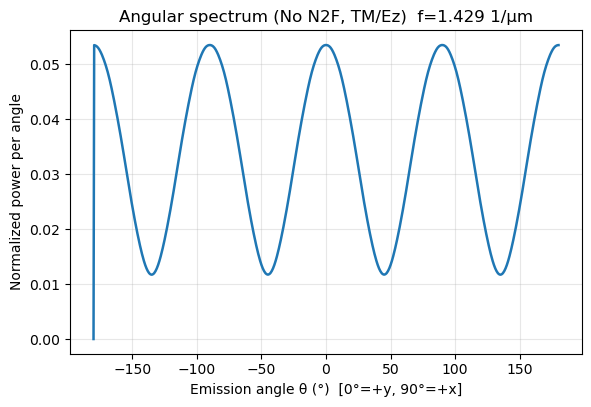

In [ ]:
# 8) 결과 시각화 (중앙 주파수 한 장)
fi0 = np.argmin(np.abs(freqs - fcen))
plt.figure(figsize=(6.6,4.2))
plt.plot(theta_grid, Pat_theta[fi0], lw=1.8)
# plt.xlim(-180, 180); plt.ylim(0, 1.05)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Normalized power per angle")
plt.title(f"Angular spectrum (No N2F, TM/Ez)  f={freqs[fi0]:.3f} 1/µm")
plt.grid(True, alpha=0.3)
plt.show()

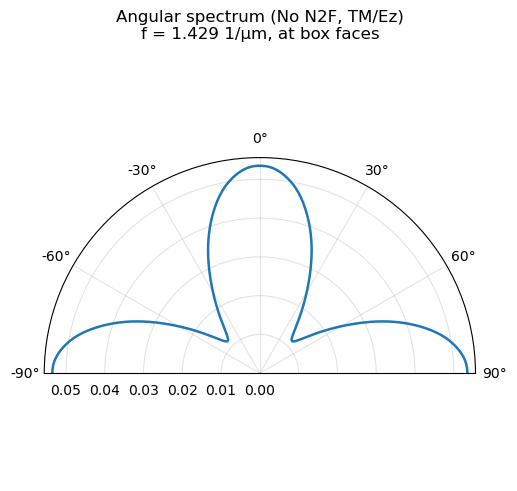

In [124]:
# === 반폴라(−90°~+90°) 플롯: 정규화 없음 ===
import numpy as np
import matplotlib.pyplot as plt

fi0 = np.argmin(np.abs(freqs - fcen))   # 중앙 주파수 인덱스(원하면 바꿔)
angles_deg = theta_grid                 # [-180, 180]
vals       = Pat_theta[fi0]             # 정규화 없는 원 데이터

# 반폴라 범위만 추출
mask = (angles_deg >= -90) & (angles_deg <= 90)
theta_half = np.deg2rad(angles_deg[mask])   # [rad]
r_half     = vals[mask]

# 반폴라 그래프
fig = plt.figure(figsize=(6.2,5.6))
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')   # 0°를 위(+y)로
ax.set_theta_direction(-1)        # 시계방향으로 각도 증가(오른쪽이 +90°)
ax.set_thetamin(-90)              # 표시 범위 제한
ax.set_thetamax(90)

ax.plot(theta_half, r_half, lw=1.8)
ax.set_rlabel_position(135)       # 반폴라에서 반지름 레이블 위치 가독성 향상
# 축 범위(원하면 고정): ax.set_rlim(0, np.max(r_half)*1.05)

ax.grid(True, alpha=0.35)
ax.set_title(f"Angular spectrum (No N2F, TM/Ez)\n"
             f"f = {freqs[fi0]:.3f} 1/µm, at box faces", va='bottom')
plt.show()


In [89]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(0, 0, 0)
    )
    for offset in offsets
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        k_point=k0
    )
    for src in sources
]

In [90]:
# inner_x = Sx - 2*tpml
# inner_y = Sy - 2*tpml

# # 모니터가 놓일 중심 좌표
# y_off = 0.5 * inner_y     # y축 상·하단
# x_off = 0.5 * inner_x     # x축 좌·우단

nearfield_box = sims[0].add_dft_fields(
    [mp.Ez],
    fcen, 0, 1,
    # y축 상단
    center = mp.Vector3(0,0,0),
    size = mp.Vector3(10-tpml*2-2/resolution,10-tpml*2-2/resolution)
)

<Axes: xlabel='X', ylabel='Y'>

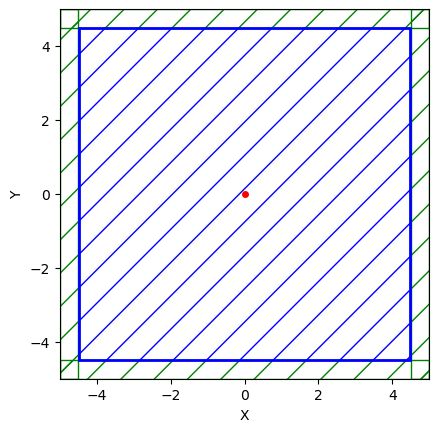

In [91]:
sims[0].plot2D()

In [92]:
sims[0].run(until_after_sources=mp.stop_when_dft_decayed())

-----------
Initializing structure...
time for choose_chunkdivision = 0.000174046 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
time for set_epsilon = 0.133753 s
-----------
run 0 finished at t = 21.94 (2194 timesteps)


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


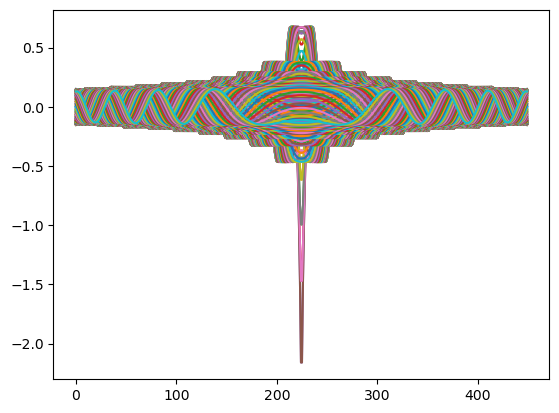

In [93]:
Ez_dft =sims[0].get_dft_array(nearfield_box,mp.Ez,0)
plt.plot(Ez_dft)
# sims[0].run(until=1)
# sims[0].plot2D(fields=mp.Ez)

In [20]:
r = 10

# resolution of far fields (points/μm)
res_ff = 1

far_flux_box = (nearfield_box.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] -
                nearfield_box.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=-r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] +
                nearfield_box.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0] -
                nearfield_box.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(-r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0])

In [21]:
npts = 360  # number of points in [0,2*pi) range of angles
angles = 2*math.pi/npts*np.arange(npts)

E = np.zeros((npts,3),dtype=np.complex128)
H = np.zeros((npts,3),dtype=np.complex128)
for n in range(npts):
    ff = sims[0].get_farfield(nearfield_box,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E[n,:] = [ff[j] for j in range(3)]
    H[n,:] = [ff[j+3] for j in range(3)]

Px = np.real(np.conj(E[:, 1]) * H[:, 2] - np.conj(E[:, 2]) * H[:, 1])
Py = np.real(np.conj(E[:, 2]) * H[:, 0] - np.conj(E[:, 0]) * H[:, 2])
Pr = np.sqrt(np.square(Px) + np.square(Py))

# integrate the radial flux over the circle circumference
far_flux_circle = np.sum(Pr)*2*np.pi*r/len(Pr)

print("flux:,  {:.6f}, {:.6f}".format(far_flux_box,far_flux_circle))

flux:,  0.349307, 0.338207


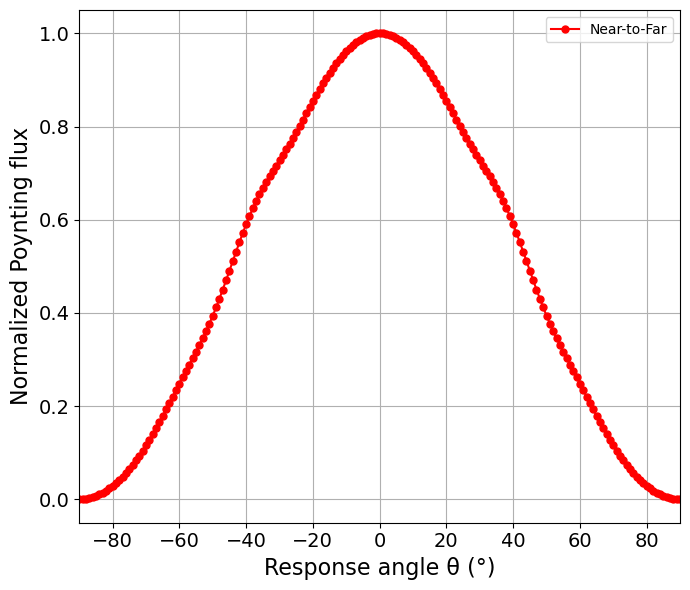

In [34]:
angles_deg = np.degrees(angles) -90

angle_min = -90
angle_max =  90

mask      = (angles_deg >= angle_min) & (angles_deg <= angle_max)
angles_sel = angles_deg[mask]
Pr_sel     = Pr[mask]

Pr_sel /= np.max(Pr_sel)

plt.figure(figsize=(7,6))
plt.plot(angles_sel, Pr_sel, 'ro-', markersize=5, label='Near-to-Far')
plt.xlim(angle_min, angle_max)
plt.xlabel("Response angle θ (°)", fontsize=16)
plt.ylabel("Normalized Poynting flux", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

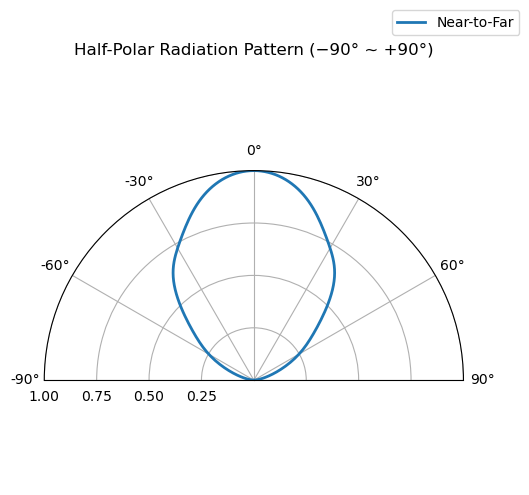

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# angles_sel: degrees in [-90, +90], Pr_sel: normalized [0,1]
theta = np.radians(angles_sel)   # polar plot은 라디안 필요
r = Pr_sel

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='polar')

# 0°를 위쪽(North)으로, 시계방향 증가 (원하면 제거/수정 가능)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# 반원(−90° ~ +90°)만 보이도록 제한
ax.set_thetamin(-90)
ax.set_thetamax(90)

# 데이터 플롯
ax.plot(theta, r, linewidth=2, label='Near-to-Far')

# 반径 범위/라벨
ax.set_rlim(0, 1.0)
ax.set_rticks([0.25, 0.5, 0.75, 1.0])
ax.set_rlabel_position(90)   # 반径 라벨을 왼쪽(90°) 근처로 이동

ax.set_title('Half-Polar Radiation Pattern (−90° ~ +90°)', va='bottom')
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()
